In [0]:
# 런타임 -> 런타임 유형변경 들어가서 gpu or tpu설정
# gpu버전 graphic 확인
!nvidia-smi

Tue Sep  3 07:42:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    72W / 149W |    482MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from pprint import pprint
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier # rf분류기
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

In [0]:
# data load
train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/data/train_1.csv')
test_data_1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/data/test1_1.csv')
test_data_2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/data/test2_1.csv')
survival_label = train_data['survival_time']
amount_spent_label = train_data['law_amount_spent']

In [0]:
print(train_data.shape)
print(test_data_1.shape)
print(test_data_2.shape)

(40000, 231)
(20000, 228)
(20000, 228)


In [0]:
test_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 228 entries, acc_id to combat_num_opponent_4
dtypes: float64(227), int64(1)
memory usage: 34.8 MB


In [0]:
test_data_1.columns

Index(['acc_id', 'death', 'enchant_count', 'exp_recovery', 'fishing',
       'game_money_change', 'npc_kill', 'party_exp', 'playtime',
       'private_shop',
       ...
       'combat_same_pledge_cnt_3', 'combat_etc_cnt_3', 'combat_num_opponent_3',
       'combat_pledge_cnt_4', 'combat_random_attacker_cnt_4',
       'combat_random_defender_cnt_4', 'combat_temp_cnt_4',
       'combat_same_pledge_cnt_4', 'combat_etc_cnt_4',
       'combat_num_opponent_4'],
      dtype='object', length=228)

In [0]:
train_data = train_data.drop('survival_time', axis=1)
train_data = train_data.drop('law_amount_spent', axis=1)
train_data = train_data.drop('acc_id', axis=1)

test_data_1 = test_data_1.drop('acc_id', axis=1)
test_data_2 = test_data_2.drop('acc_id', axis=1)

In [0]:
print(train_data.shape)
print(test_data_1.shape)
print(test_data_2.shape)

(40000, 228)
(20000, 227)
(20000, 227)


In [0]:
test_data_col = test_data_1.columns

In [0]:
#train_data = train_data.set_index(test_data_col)
train_data = pd.DataFrame(train_data, columns=test_data_col)

In [0]:
# test_data_1 = pd.DataFrame(test_data_1, columns=train_data_col)
# test_data_2 = pd.DataFrame(test_data_2, columns=train_data_col)

In [0]:
print(train_data.shape)
print(test_data_1.shape)
print(test_data_2.shape)

(40000, 227)
(20000, 227)
(20000, 227)


In [0]:
print(train_data.columns)
print(test_data_1.columns)

Index(['death', 'enchant_count', 'exp_recovery', 'fishing',
       'game_money_change', 'npc_kill', 'party_exp', 'playtime',
       'private_shop', 'quest_exp',
       ...
       'combat_same_pledge_cnt_3', 'combat_etc_cnt_3', 'combat_num_opponent_3',
       'combat_pledge_cnt_4', 'combat_random_attacker_cnt_4',
       'combat_random_defender_cnt_4', 'combat_temp_cnt_4',
       'combat_same_pledge_cnt_4', 'combat_etc_cnt_4',
       'combat_num_opponent_4'],
      dtype='object', length=227)
Index(['death', 'enchant_count', 'exp_recovery', 'fishing',
       'game_money_change', 'npc_kill', 'party_exp', 'playtime',
       'private_shop', 'quest_exp',
       ...
       'combat_same_pledge_cnt_3', 'combat_etc_cnt_3', 'combat_num_opponent_3',
       'combat_pledge_cnt_4', 'combat_random_attacker_cnt_4',
       'combat_random_defender_cnt_4', 'combat_temp_cnt_4',
       'combat_same_pledge_cnt_4', 'combat_etc_cnt_4',
       'combat_num_opponent_4'],
      dtype='object', length=227)


In [0]:
# # data preprocessing

# from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# #train_data = MinMaxScaler().fit_transform(train_data)
# #test_data_1 = MinMaxScaler().fit_transform(test_data_1)
# #test_data_2 = MinMaxScaler().fit_transform(test_data_2)

# train_data = preprocessing.robust_scale(train_data)
# test_data_1 = preprocessing.robust_scale(test_data_1)
# test_data_2 = preprocessing.robust_scale(test_data_2)

In [0]:
#### xgb
grid_result = []
param = {}
#### XGB parameters
## General Parameters
param['n_gpus'] = -1
param['tree_method'] = 'gpu_hist'
param['silent'] = 0

## Booster Parameters
param['n_estimators'] = 512 #요기...
param['learning_rate'] = 0.01
param['min_child_weight'] = 6.5
param['max_depth'] = 13
param['gamma'] = 0.1
param['reg_alpha'] =0.01
param['reg_lambda'] = 0.05
param['subsample'] = 0.9
param['colsample_bytree'] = 0.75
param['scale_pos_weight'] = 1

## Learning task parameters
param['num_class'] = 64
param['objective'] = 'multi:softmax'
param['seed'] = 321

## update?
#param['process_type'] = 'update'
#param['updater'] = 'refresh'
#param['refresh_leaf'] = True
model = xgb.XGBClassifier(**param)

In [0]:
#### 전체 데이터 학습
model = xgb.XGBClassifier(**param)
model.fit(train_data, survival_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.1,
              learning_rate=0.01, max_delta_step=0, max_depth=13,
              min_child_weight=6.5, missing=None, n_estimators=512, n_gpus=-1,
              n_jobs=1, nthread=None, num_class=64, objective='multi:softprob',
              random_state=0, reg_alpha=0.01, reg_lambda=0.05,
              scale_pos_weight=1, seed=321, silent=0, subsample=0.9,
              tree_method='gpu_hist', verbosity=1)

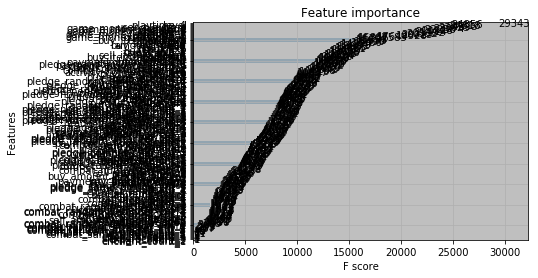

In [0]:
from matplotlib import pyplot
xgb.plot_importance(model)
pyplot.show()

In [0]:
# feature selection

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(model, prefit=True)
X_train_new = model.transform(train_data)
X_test_new1 = model.transform(test_data_1)
X_test_new2 = model.transform(test_data_2)

In [0]:
#### xgb
grid_result = []
param = {}
#### XGB parameters
## General Parameters
param['n_gpus'] = -1
param['tree_method'] = 'gpu_hist'
param['silent'] = 0

## Booster Parameters
param['n_estimators'] = 512 #요기...
param['learning_rate'] = 0.01
param['min_child_weight'] = 6.5
param['max_depth'] = 13
param['gamma'] = 0.1
param['reg_alpha'] =0.01
param['reg_lambda'] = 0.05
param['subsample'] = 0.9
param['colsample_bytree'] = 0.75
param['scale_pos_weight'] = 1

## Learning task parameters
param['num_class'] = 64
param['objective'] = 'multi:softmax'
param['seed'] = 321

## update?
#param['process_type'] = 'update'
#param['updater'] = 'refresh'
#param['refresh_leaf'] = True
model1 = xgb.XGBClassifier(**param)

In [0]:
#### 전체 데이터 학습
model1 = xgb.XGBClassifier(**param)
model1.fit(X_train_new, survival_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.1,
              learning_rate=0.01, max_delta_step=0, max_depth=13,
              min_child_weight=6.5, missing=None, n_estimators=512, n_gpus=-1,
              n_jobs=1, nthread=None, num_class=64, objective='multi:softprob',
              random_state=0, reg_alpha=0.01, reg_lambda=0.05,
              scale_pos_weight=1, seed=321, silent=0, subsample=0.9,
              tree_method='gpu_hist', verbosity=1)

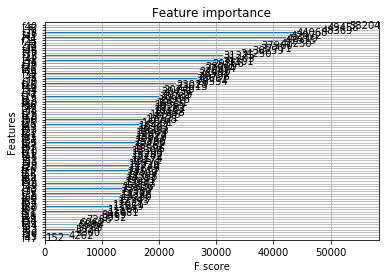

In [0]:
from matplotlib import pyplot
xgb.plot_importance(model1)
pyplot.show()

In [0]:
from sklearn.metrics import accuracy_score
predictions_1 = model1.predict(X_test_new1)
predictions_2 = model1.predict(X_test_new2)

df_1 = pd.DataFrame(predictions_1)
df_2 = pd.DataFrame(predictions_2)

#df_1 = df_1.rename(columns = {'0':'survival_time'})
#df_2 = df_2.rename(columns = {'0':'survival_time'})

df_1.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test1_result1_5.csv')
df_2.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test2_result1_5.csv')

In [0]:
pip install catboost

In [0]:
# data preprocessing

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#train_data = StandardScaler().fit_transform(train_data)
#test_data_1 = StandardScaler().fit_transform(test_data_1)
#test_data_2 = MinMaxScaler().fit_transform(test_data_2)

train_data = preprocessing.robust_scale(train_data)
test_data_1 = preprocessing.robust_scale(test_data_1)
test_data_2 = preprocessing.robust_scale(test_data_2)

In [0]:
from catboost import CatBoostRegressor

In [0]:
model_cat = CatBoostRegressor(iterations=10000,
                              task_type="GPU")
# Fit model
model_cat.fit(train_data, amount_spent_label)
# Get predictions
#preds = model_cat.predict(eval_data)

0:	learn: 0.7308666	total: 70.9ms	remaining: 11m 49s
1:	learn: 0.7289116	total: 140ms	remaining: 11m 38s
2:	learn: 0.7270488	total: 208ms	remaining: 11m 34s
3:	learn: 0.7246337	total: 270ms	remaining: 11m 14s
4:	learn: 0.7226230	total: 339ms	remaining: 11m 17s
5:	learn: 0.7201380	total: 405ms	remaining: 11m 14s
6:	learn: 0.7183124	total: 457ms	remaining: 10m 52s
7:	learn: 0.7166321	total: 516ms	remaining: 10m 44s
8:	learn: 0.7134061	total: 578ms	remaining: 10m 41s
9:	learn: 0.7115184	total: 626ms	remaining: 10m 25s
10:	learn: 0.7094757	total: 682ms	remaining: 10m 18s
11:	learn: 0.7073416	total: 731ms	remaining: 10m 8s
12:	learn: 0.7058793	total: 792ms	remaining: 10m 8s
13:	learn: 0.7037888	total: 858ms	remaining: 10m 11s
14:	learn: 0.7018152	total: 908ms	remaining: 10m 4s
15:	learn: 0.7001290	total: 956ms	remaining: 9m 56s
16:	learn: 0.6986114	total: 1s	remaining: 9m 50s
17:	learn: 0.6977836	total: 1.06s	remaining: 9m 46s
18:	learn: 0.6959727	total: 1.1s	remaining: 9m 38s
19:	learn: 0.

In [0]:
from sklearn.metrics import accuracy_score
predictions_1 = model_cat.predict(test_data_1)
predictions_2 = model_cat.predict(test_data_2)

for i in range(len(predictions_1)):
    if predictions_1[i] <= 0:
          predictions_1[i] = 0
    if predictions_2[i] <= 0:
          predictions_2[i] = 0
df_1 = pd.DataFrame(predictions_1)
df_2 = pd.DataFrame(predictions_2)

#df_1 = df_1.rename(columns = {'0':'survival_time'})
#df_2 = df_2.rename(columns = {'0':'survival_time'})

df_1.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test1_result1_6_re.csv')
df_2.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test2_result1_6_re.csv')

In [0]:
import xgboost

model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 n_gpus = -1,
                 tree_method = 'gpu_hist',           
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=321) 

In [0]:
model.fit(train_data, amount_spent_label)

[01:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_gpus=-1, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=321, silent=None,
             subsample=0.6, tree_method='gpu_hist', verbosity=1)

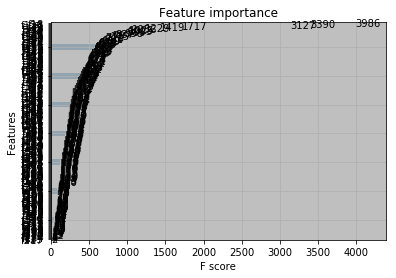

In [0]:
from matplotlib import pyplot
xgboost.plot_importance(model)
pyplot.show()

In [0]:
from sklearn.metrics import accuracy_score
predictions_1 = model.predict(test_data_1)
predictions_2 = model.predict(test_data_2)

for i in range(len(predictions_1)):
    if predictions_1[i] <= 0:
          predictions_1[i] = 0
    if predictions_2[i] <= 0:
          predictions_2[i] = 0
df_1 = pd.DataFrame(predictions_1)
df_2 = pd.DataFrame(predictions_2)

#df_1 = df_1.rename(columns = {'0':'survival_time'})
#df_2 = df_2.rename(columns = {'0':'survival_time'})

df_1.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test1_result1_4_re.csv')
df_2.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test2_result1_4_re.csv')

In [0]:
# feature selection

from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(model, prefit=True)
X_train_new = model.transform(train_data)
X_test_new1 = model.transform(test_data_1)
X_test_new2 = model.transform(test_data_2)

In [0]:
import xgboost

model1 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 n_gpus = -1,
                 tree_method = 'gpu_hist',           
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=321)

In [0]:
model1.fit(X_train_new, amount_spent_label)

[02:04:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None,
             n_estimators=10000, n_gpus=-1, n_jobs=1, nthread=None,
             objective='reg:linear', random_state=0, reg_alpha=0.75,
             reg_lambda=0.45, scale_pos_weight=1, seed=321, silent=None,
             subsample=0.6, tree_method='gpu_hist', verbosity=1)

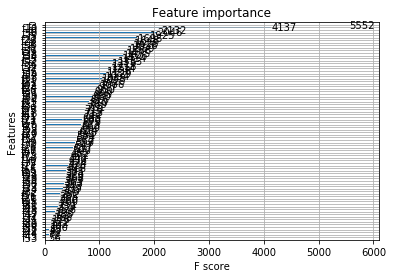

In [0]:
from matplotlib import pyplot
xgboost.plot_importance(model1)
pyplot.show()

In [0]:
from sklearn.metrics import accuracy_score
predictions_1 = model1.predict(X_test_new1)
predictions_2 = model1.predict(X_test_new2)

for i in range(len(predictions_1)):
    if predictions_1[i] <= 0:
          predictions_1[i] = 0
    if predictions_2[i] <= 0:
          predictions_2[i] = 0
df_1 = pd.DataFrame(predictions_1)
df_2 = pd.DataFrame(predictions_2)

#df_1 = df_1.rename(columns = {'0':'survival_time'})
#df_2 = df_2.rename(columns = {'0':'survival_time'})

df_1.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test1_result1_5_re.csv')
df_2.to_csv('/content/drive/My Drive/Colab Notebooks/bigcontest/result/190903_test2_result1_5_re.csv')